# IMDb Films Dataset Analysis

<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/IMDB_Logo_2016.svg" width="400">

The dataset used in this analysis can be downloaded from the following URL: https://www.kaggle.com/datasets/ashpalsingh1525/imdb-movies-dataset/data

Date of data download: 03/06/2023

## Table of Contents
* [0 - Initialization](#initialization-header)
* [1 - Preprocess the dataset](#preprocess-header)
* [2 - Analysis](#analysis-header)
    * [What are the top scoring languages (excluding English)?](#language-header)
    * [Which are the countries that produce more films?](#countries-header)
    * [Which is the genre that gives more net income? And the one that has more score?](#genre-header)
    * [Is there a time series trend in the film production?](#trend-header)
    * [Who are the actors with the most movies? And the best in terms of scoring in movies they participate in?](#actors-header)

## 0 - Initialization <a class="anchor" id="initialization-header"></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Set the color for the plots with one series
imdbcolor = '#F5C518'

In [2]:
# Load the dataset
df = pd.read_csv('imdb_movies.csv', parse_dates=['date_x'])
df = df.sort_values('date_x').reset_index(drop=True)
df.head(10)

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,The Life and Passion of Jesus Christ,1903-05-15,63.0,"Drama, History","The story of Jesus Christ, from the proclamati...","Madame Moreau, Virgin Mary, Monsieur Moreau, J...",La vie et la passion de Jésus Christ,Released,French,106400000.0,524759370.4,FR
1,A Trip to the Moon,1907-06-20,80.0,"Adventure, Science Fiction",Professor Barbenfouillis and five of his colle...,"Georges Méliès, Professor Barbenfouillis / The...",Le Voyage dans la Lune,Released,French,5985.0,39962472.4,AU
2,The Birth of a Nation,1915-02-08,61.0,"Drama, History, War","Two families, abolitionist Northerners the Sto...","Lillian Gish, Stoneman's Daughter Elsie, Mae M...",The Birth of a Nation,Released,English,110000.0,11000000.0,US
3,The Birth of a Nation,1915-02-08,61.0,"Drama, History, War","Two families, abolitionist Northerners the Sto...","Lillian Gish, Stoneman's Daughter Elsie, Mae M...",The Birth of a Nation,Released,English,10000000.0,16891011.0,US
4,The Cabinet of Dr. Caligari,1920-02-27,80.0,"Drama, Horror, Thriller, Crime","Francis, a young man, recalls in his memory th...","Werner Krauß, Dr. Caligari, Conrad Veidt, Cesa...",Das Cabinet des Dr. Caligari,Released,German,18000.0,8811.0,DE
5,Safety Last!,1923-04-01,79.0,"Comedy, Romance, Thriller",When a store clerk organizes a contest to clim...,"Harold Lloyd, The Boy - Harold, Mildred Davis,...",Safety Last!,Released,English,121000.0,1500000.0,US
6,The Ten Commandments,1923-11-23,68.0,Drama,The first part tells the story of Moses leadin...,"Theodore Roberts, Moses - The Lawgiver, Charle...",The Ten Commandments,Released,English,10000000.0,1051907.0,US
7,The Ten Commandments,1923-11-23,68.0,Drama,The first part tells the story of Moses leadin...,"Theodore Roberts, Moses - The Lawgiver, Charle...",The Ten Commandments,Released,English,13500000.0,85433929.0,US
8,Battleship Potemkin,1925-12-24,76.0,"Drama, History",A dramatized account of a great Russian naval ...,"Aleksandr Antonov, Grigory Vakulinchuk, Vladim...",Броненосец Потёмкин,Released,Russian,5389600.0,45100.0,SU
9,Ben-Hur: A Tale of the Christ,1925-12-30,74.0,"Adventure, Drama, Romance","Erstwhile childhood friends, Judah Ben-Hur and...","Ramon Novarro, Judah Ben-Hur, Francis X. Bushm...",Ben-Hur: A Tale of the Christ,Released,English,3900000.0,9000000.0,US


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   names       10178 non-null  object        
 1   date_x      10178 non-null  datetime64[ns]
 2   score       10178 non-null  float64       
 3   genre       10093 non-null  object        
 4   overview    10178 non-null  object        
 5   crew        10122 non-null  object        
 6   orig_title  10178 non-null  object        
 7   status      10178 non-null  object        
 8   orig_lang   10178 non-null  object        
 9   budget_x    10178 non-null  float64       
 10  revenue     10178 non-null  float64       
 11  country     10178 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 954.3+ KB


## 1 - Preprocess the dataset <a class="anchor" id="preprocess-header"></a>

In [4]:
# Convert 0 to NaN in budget and revenue fields
df['budget_x'] = np.where(df['budget_x'] < 1e-3, np.nan, df['budget_x'])
df['revenue'] = np.where(df['revenue'] < 1e-3, np.nan, df['revenue'])

# Transform the units of budget and revenue into millions of dollars
df[['budget_x', 'revenue']] = df[['budget_x', 'revenue']] / 1e6

### Fix the duplicated rows

In [5]:
# Check if duplicates
df_duplicated = df[df.duplicated(['names', 'date_x', 'overview'], keep=False)]
df_duplicated['idx'] = df_duplicated.index
df_duplicated.sort_values('date_x')

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,idx
2,The Birth of a Nation,1915-02-08,61.0,"Drama, History, War","Two families, abolitionist Northerners the Sto...","Lillian Gish, Stoneman's Daughter Elsie, Mae M...",The Birth of a Nation,Released,English,0.11,11.000000,US,2
3,The Birth of a Nation,1915-02-08,61.0,"Drama, History, War","Two families, abolitionist Northerners the Sto...","Lillian Gish, Stoneman's Daughter Elsie, Mae M...",The Birth of a Nation,Released,English,10.00,16.891011,US,3
6,The Ten Commandments,1923-11-23,68.0,Drama,The first part tells the story of Moses leadin...,"Theodore Roberts, Moses - The Lawgiver, Charle...",The Ten Commandments,Released,English,10.00,1.051907,US,6
7,The Ten Commandments,1923-11-23,68.0,Drama,The first part tells the story of Moses leadin...,"Theodore Roberts, Moses - The Lawgiver, Charle...",The Ten Commandments,Released,English,13.50,85.433929,US,7
22,King Kong,1933-03-15,76.0,"Adventure, Fantasy, Horror","Adventurous filmmaker, Carl Denham, sets out t...","Robert Armstrong, Carl Denham, Fay Wray, Ann D...",King Kong,Released,English,23.00,90.614445,US,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9887,After,2023-02-22,60.0,Drama,A club in Paris. Driving techno beats sweep ev...,"Louise Chevillotte, Félicie, Majd Mastoura, Sa...",After,Released,French,0.65,NaN,BR,9887
10038,Thunder Monk,2023-04-06,40.0,"Action, Comedy","The story of Phra Jued (Oat), a monk with a st...","Pramote Pathan, , Pongkool Suebsung, , Sananth...",อาตมาฟ้าผ่า,Released,Thai,112.80,858.637629,TH,10038
10039,Thunder Monk,2023-04-06,0.0,"Action, Comedy","The story of Phra Jued (Oat), a monk with a st...","Pramote Pathan, , Pongkool Suebsung, , Sananth...",Thunder Monk,Released,Thai,198.00,175.269999,TH,10039
10105,Life,2023-04-09,0.0,Drama,"Mehmet's daughter, Hicran, ran away from home ...","Miray Daner, Hicran, Burak Dakak, Rıza, Umut K...",Hayat,Released,Turkish,58.00,101.815660,TR,10105


Duplicated films need to be removed, I will use a mininimum value criteria for budget_x field to keep one of each duplicated film.

In [6]:
dup_to_keep = df_duplicated.groupby(['names', 'date_x']).agg({'budget_x': 'min', 'idx': 'first'}).reset_index()
dup_to_drop = df_duplicated[~df_duplicated.index.isin(dup_to_keep['idx'])]

# Drop from df
df.drop(dup_to_drop.index, axis=0, inplace=True)

### Reduce categories for genres field

In [7]:
df['genre'].value_counts()

genre
Drama                                           550
Comedy                                          372
Drama, Romance                                  262
Horror                                          248
Horror, Thriller                                189
                                               ... 
Action, Adventure, Comedy, TV Movie               1
Animation, Drama, Family, Romance                 1
Action, Adventure, Comedy, Drama, Animation       1
Fantasy, Drama, Thriller, Romance                 1
Comedy, Animation, Family, Action, Adventure      1
Name: count, Length: 2303, dtype: int64

As we can see, there are a lot of unique values (more than 2k!) as in each film can be more than 4 genres at once. I'm going to truncate to 2 the maximum different genres in each film.

In [8]:
# First, set 'Unknown' for NaN values
df['genre'] = df['genre'].fillna("Unknown")

In [9]:
def unify_genre(genre: pd.DataFrame):
    # Remove the escape characters
    genre = [item.replace('\xa0', '') for item in genre]
    
    # Return the values sorted
    return ', '.join(sorted(genre)) # Sorted so that, e.g., "Action, Adventure" equals as "Adventure, Action"

# Grab only the first two genres
df['genre'] = df['genre'].apply(lambda x: x.split(',')[:2])
df['genre'] = df['genre'].apply(unify_genre)

In [10]:
df['genre'].value_counts()

genre
Drama                   550
Action, Adventure       486
Drama, Romance          459
Comedy, Drama           388
Comedy                  372
                       ... 
Romance, War              1
Crime, History            1
Comedy, History           1
Mystery, Romance          1
Documentary, Mystery      1
Name: count, Length: 157, dtype: int64

### Add new useful columns

In [11]:
# Compute the net income of each film
df['net_income'] = df['revenue'] - df['budget_x']

In [12]:
# Extract the name of the actors in crew field
def retrieve_actors(actor_character):
    actors = [nombre.strip() for i, nombre in enumerate(actor_character.split(',')) if i % 2 == 0]
    return ', '.join(actors)
df['cast'] = df['crew'].fillna('').apply(retrieve_actors)

### Recap of the dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 10177
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   names       9999 non-null   object        
 1   date_x      9999 non-null   datetime64[ns]
 2   score       9999 non-null   float64       
 3   genre       9999 non-null   object        
 4   overview    9999 non-null   object        
 5   crew        9943 non-null   object        
 6   orig_title  9999 non-null   object        
 7   status      9999 non-null   object        
 8   orig_lang   9999 non-null   object        
 9   budget_x    9999 non-null   float64       
 10  revenue     9934 non-null   float64       
 11  country     9999 non-null   object        
 12  net_income  9934 non-null   float64       
 13  cast        9999 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(9)
memory usage: 1.1+ MB


## 2 - Analysis <a class="anchor" id="analysis-header"></a>

### What are the top scoring languages (excluding English)? <a class="anchor" id="language-header"></a>

In [14]:
# Get the 10 most represented languages
top10_lang = df['orig_lang'].value_counts()[:11].index.drop(' English')
df[df['orig_lang'].isin(top10_lang)].groupby('orig_lang')['score'].mean().sort_values(ascending=False).head(10)

orig_lang
 Japanese              66.883427
 Spanish, Castilian    65.188917
 French                64.867857
 German                62.569892
 Chinese               61.620915
 Italian               61.087591
 Russian               60.696970
 Cantonese             60.068966
 Korean                54.894330
 Tagalog               40.813953
Name: score, dtype: float64

In the table above we can see how the Japanese is the ```orig_lang``` with best scoring excluding English.

### Which are the countries that produce more films? <a class="anchor" id="countries-header"></a>

In [15]:
# Import the polygons of the countries of the world for mapping purposes as a GeoDataFrame
gdf = gpd.read_file("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/World_Countries_(Generalized)/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FID            251 non-null    int64   
 1   COUNTRY        251 non-null    object  
 2   ISO            251 non-null    object  
 3   COUNTRYAFF     251 non-null    object  
 4   AFF_ISO        251 non-null    object  
 5   Shape__Area    251 non-null    float64 
 6   Shape__Length  251 non-null    float64 
 7   geometry       251 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 15.8+ KB


In [16]:
# Merge the GeoDataFrame with the counting data of IMDB DataFrame
gdf = pd.merge(gdf, df['country'].value_counts(), left_on='ISO', right_on='country', how='left')

In [17]:
from jenkspy import JenksNaturalBreaks

# 1D cluster count data into groups for better graphical representation

jnb = JenksNaturalBreaks(n_classes=5) # Cluster the data into 5 classes
jnb.fit(gdf['count'].fillna(0)) # Replace NaN with 0 to avoid error

# Get the class of each country
gdf['count_class'] = jnb.predict(gdf['count'])

# Replace the 0 to NaN as it was before
gdf.loc[gdf['count'].isna(), 'count_class'] = np.nan

Text(0.5, 1.1, 'World film production by country')

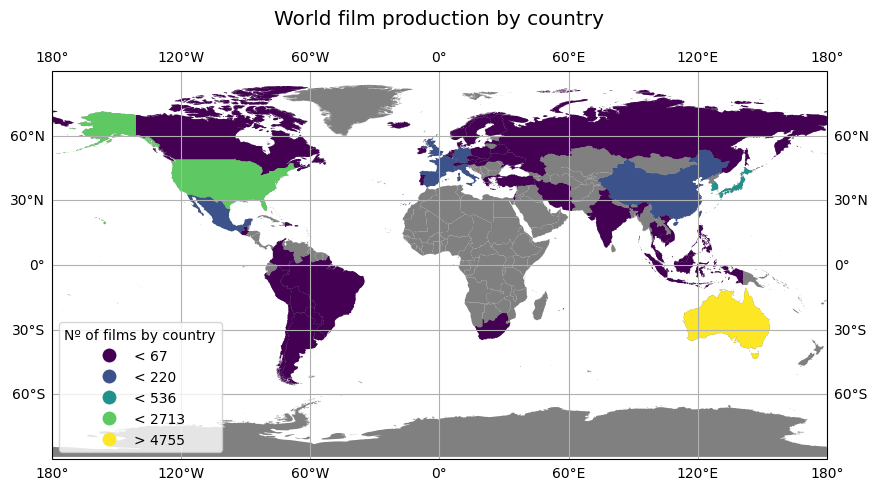

In [18]:
# Get the thresholds and convert them into labels to be added in the legend
legend_labels = ["< %.0f" % label if i != len(jnb.breaks_[1:]) - 1 else "> %.0f" % label for i, label in enumerate(jnb.breaks_[1:])]

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Plot all the worlds with no data in gray color
gdf.plot(color='gray', ax=ax, label="No Data", legend=True)
# Plot all countries present in IMDB dataset
gdf.plot(column='count_class',
         cmap='viridis',
         categorical=True,
         legend=True,
         legend_kwds={'loc': 'lower left',
                      'title': 'Nº of films by country'},
         ax=ax)
ax.gridlines(draw_labels=True)
for label, newlabel in zip(ax.get_legend().texts, legend_labels):
    label.set_text(newlabel)
ax.set_title('World film production by country', y=1.1, fontsize='x-large')

Clearly there is something wrong with ```country``` field, since the country that produces the most films is obviously not Australia.

In [19]:
df[df['country'] == 'AU'].sort_values(by='revenue', ascending=False).head(5)

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,net_income,cast
4181,Avatar,2009-12-17,76.0,"Action, Adventure","In the 22nd century, a paraplegic Marine is di...","Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar,Released,English,237.0,2923.706026,AU,2686.706026,"Sam Worthington, Zoe Saldaña, Sigourney Weaver..."
7426,Avengers: Endgame,2019-04-24,83.0,"Adventure, Science Fiction",After the devastating events of Avengers: Infi...,"Robert Downey Jr., Tony Stark / Iron Man, Chri...",Avengers: Endgame,Released,English,400.0,2794.731755,AU,2394.731755,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ..."
9745,Avatar: The Way of Water,2022-12-15,78.0,"Adventure, Science Fiction",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460.0,2316.794914,AU,1856.794914,"Sam Worthington, Zoe Saldaña, Sigourney Weaver..."
2005,Titanic,1997-12-18,79.0,"Drama, Romance",101-year-old Rose DeWitt Bukater tells the sto...,"Leonardo DiCaprio, Jack Dawson, Kate Winslet, ...",Titanic,Released,English,200.0,2222.985568,AU,2022.985568,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K..."
5968,Star Wars: The Force Awakens,2015-12-17,73.0,"Action, Adventure",Thirty years after defeating the Galactic Empi...,"Harrison Ford, Han Solo, Mark Hamill, Luke Sky...",Star Wars: The Force Awakens,Released,English,245.0,2068.223624,AU,1823.223624,"Harrison Ford, Mark Hamill, Carrie Fisher, Ada..."


In the table above we can see how there are American films labeled as Australian.

### Which is the genre that gives more net income? And the one that has more score? <a class="anchor" id="genre-header"></a>

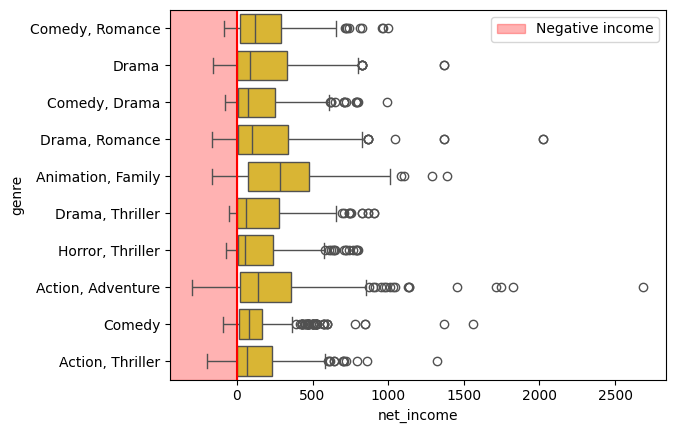

In [20]:
# Get only the first 10 most common genres
subset_top_genre = df[df['genre'].isin(df['genre'].value_counts()[:10].index)]

fig, ax = plt.subplots()
sns.boxplot(data=subset_top_genre, x='net_income', y='genre', color=imdbcolor, ax=ax)
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
ax.axvline(0, color='r')
ax.axvspan(ax.get_xlim()[0], 0, ymin=0, ymax=1, color='red', alpha=.3, label='Negative income')
ax.legend()

In terms of the interquartile range (IQR), we can see that ```Animation, Family``` genre is the one that gives the highest net income.

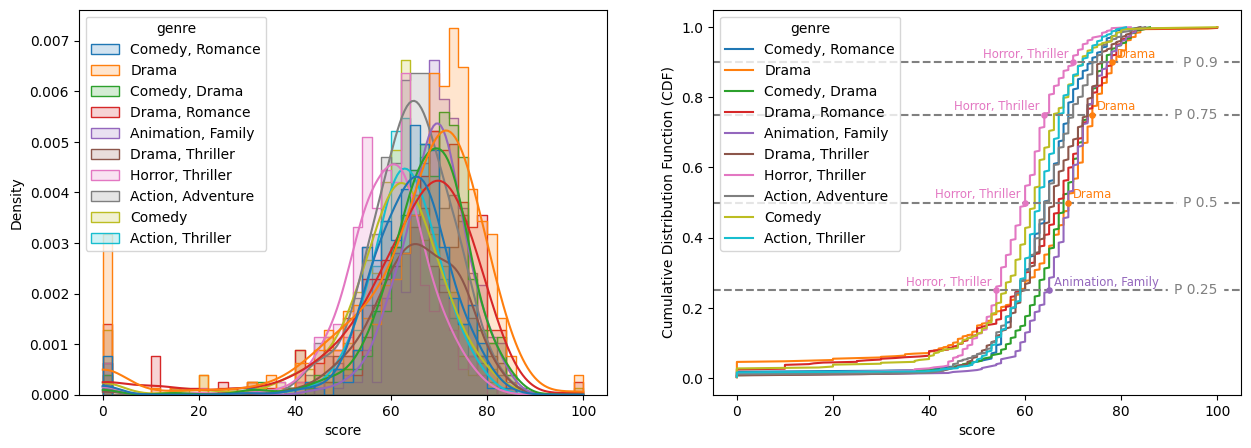

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF

# Now, let's see the distribution values for each genre by plotting a relative histogram and a CDF distribution

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(data=subset_top_genre, x='score', hue='genre', element="step", kde=True, stat="density", bins=50, alpha=.2, ax=ax[0])

# Plot the CDF
# empty dict where cdf data will be stored
cdf_values = {}

# Extract the values in this list of probabilites
probs = [0.25, 0.5, 0.75, 0.9]

# Get the list of colors used in CDF plot
colors = []

for i, genre in enumerate(subset_top_genre['genre'].unique()):

    # Get the ECDF data by using ECDF object of statsmodels package
    ecdf_data = ECDF(subset_top_genre.loc[subset_top_genre['genre'] == genre, 'score'].array)

    # Plot the ECDF
    ax[1].plot(ecdf_data.x, ecdf_data.y, label=genre)

    # Grab the color
    colors.append(ax[1].get_lines()[-1].get_color())

    # Get the idxs of the arrays where each prob is met
    idxs_probs = [np.argmin(np.abs(ecdf_data.y - prob)) for prob in probs]

    # Add a dictionary with prob:score
    cdf_values.update({genre: {prob: ecdf_data.x[idx] for idx, prob in zip(idxs_probs, probs)}})

ax[1].legend(title=subset_top_genre['genre'].name)
ax[1].set_xlabel(subset_top_genre['score'].name)
ax[1].set_ylabel('Cumulative Distribution Function (CDF)')

# Add some extra info in the plot
for prob in probs:
    # Get the respective score (y-value) for each probability among each group
    dict_prob_values = {genre: score[prob] for genre, score in cdf_values.items()}

    # Get the min value (i.e. the group with the lowest score for each probability) and its index
    min_tuple = min(dict_prob_values.items(), key=lambda x: x[1])
    idx_min_genre = list(dict_prob_values.keys()).index(min_tuple[0])

    # Get the max value (i.e. the group with the lowest score for each probability) and its index
    max_tuple = max(dict_prob_values.items(), key=lambda x: x[1])
    idx_max_genre = list(dict_prob_values.keys()).index(max_tuple[0])

    ax[1].axhline(prob, ls='--', color='gray')
    ax[1].text(100, prob, "P {}".format(prob), color='gray', bbox=dict(facecolor='white', edgecolor='white'), va='center', ha='right')
    ax[1].scatter(min_tuple[1], prob, color=colors[idx_min_genre], s=14, zorder=2)
    ax[1].text(min_tuple[1] - 1, prob + 5e-3, min_tuple[0], va='bottom', ha='right', fontsize='small', color=colors[idx_min_genre])
    ax[1].scatter(max_tuple[1], prob, color=colors[idx_max_genre], s=14, zorder=2)
    ax[1].text(max_tuple[1] + 1, prob + 5e-3, max_tuple[0], va='bottom', ha='left', fontsize='small', color=colors[idx_max_genre])

Looking at the relative histograms and the Cumulative Distribution Functions (CDFs) we can see how ```Drama``` genre has more proportion of higher scores whereas ```Horror, Thriller``` is the one with less score. If we look at the CDF plot we can also see how, for probabilities of less than ~40%, ```Animation, Family``` has higher scores than the rest of the genres.

### Is there a time series trend in the film production? <a class="anchor" id="trend-header"></a>

In [22]:
# Let's group the data in quarterly frequency.
df_quarterly = df.groupby(pd.Grouper(key='date_x', freq='3M')).agg({'date_x': 'size',
                                                                    'score': 'mean',
                                                                    'budget_x':'median',
                                                                    'revenue':'median',
                                                                    'net_income':'median'}).rename(columns={'date_x': 'count'})
df_quarterly.tail()

,count,score,budget_x,revenue,net_income
date_x,,,,,
2023-02-28,206,62.708738,87.90,345.336673,264.336673
2023-05-31,248,32.689516,136.90,175.269999,8.359863
2023-08-31,23,4.347826,223.94,175.269999,-67.640137
2023-11-30,5,0.000000,205.00,175.269999,-35.580137
2024-02-29,1,90.000000,254.00,1656.280462,1402.280462


In [23]:
# Let's keep only data until 2022
df_quarterly = df_quarterly[:-5]

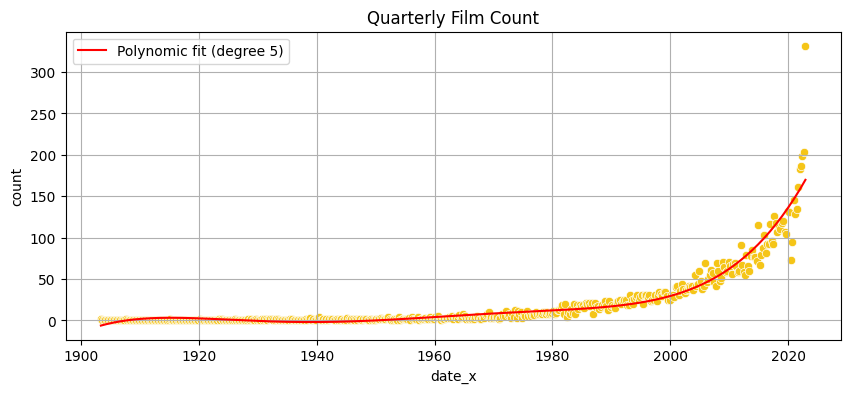

In [24]:
# Fit polynomic n degree
degree = 5
coefficients = np.polyfit(range(len(df_quarterly)), df_quarterly['count'], degree)

# Create data for the fitted curve
x_fit = np.linspace(0, max(range(len(df_quarterly))), len(df_quarterly))
y_fit = np.polyval(coefficients, x_fit)

fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=df_quarterly, x=df_quarterly.index, y='count', color=imdbcolor, ax=ax)
sns.lineplot(x=df_quarterly.index, y=y_fit, color='red', label=f'Polynomic fit (degree {degree})')
ax.set_title('Quarterly Film Count')
plt.grid(True)

We can see that there is a clearly increasing trend in the number of films produced. Now, let's look at the selected fields.

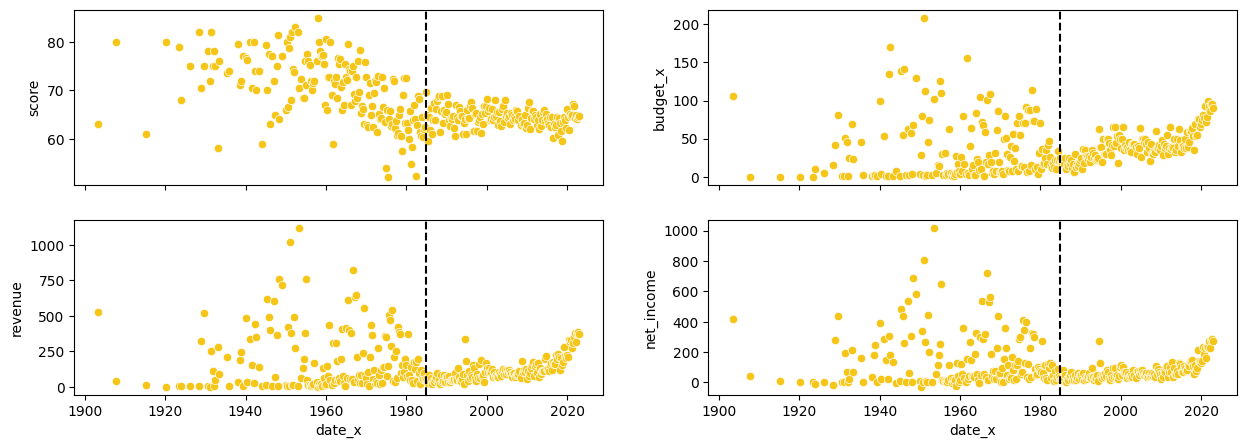

In [25]:
cols2plot = [col for col in df_quarterly.columns if col != 'count']

fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
for i, col in enumerate(cols2plot):
    ax_ = ax[i // 2, i % 2]
    sns.scatterplot(data=df_quarterly, x=df_quarterly.index, y=col, color=imdbcolor, ax=ax_)
    ax_.axvline(pd.to_datetime('1985-01-01'), color='k', ls='--')

Text(0.5, 1.0, 'After 1985')

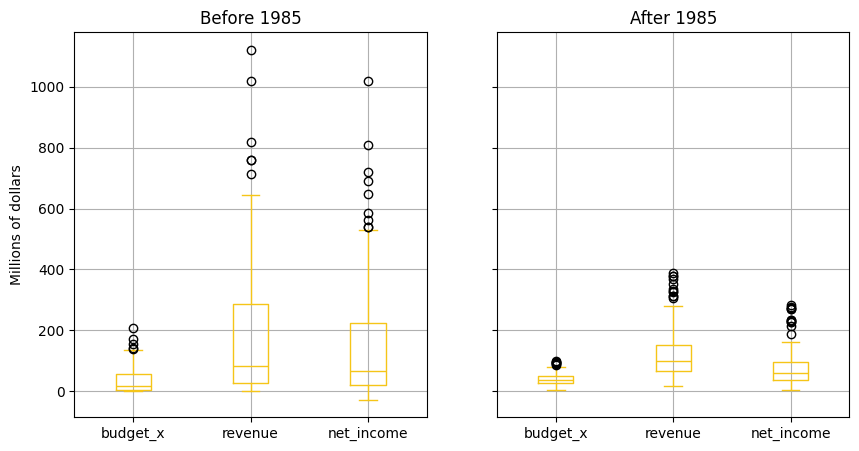

In [26]:
thres1985 = pd.Timestamp('1985-01-01')

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
df_quarterly[df_quarterly.index < thres1985][cols2plot[1:]].boxplot(ax=ax[0], color=imdbcolor)
df_quarterly[df_quarterly.index > thres1985][cols2plot[1:]].boxplot(ax=ax[1], color=imdbcolor)
ax[0].set_ylabel('Millions of dollars')
ax[0].set_title('Before 1985')
ax[1].set_title('After 1985')

Looking at the time series and box plots, we see that the data prior to ~1985 are much more sparse than those after ~1985. This is due to the small number of films prior to that year, which mean that the sample can potentially have more dispersion. We will now take a closer look at the post-1985 data.

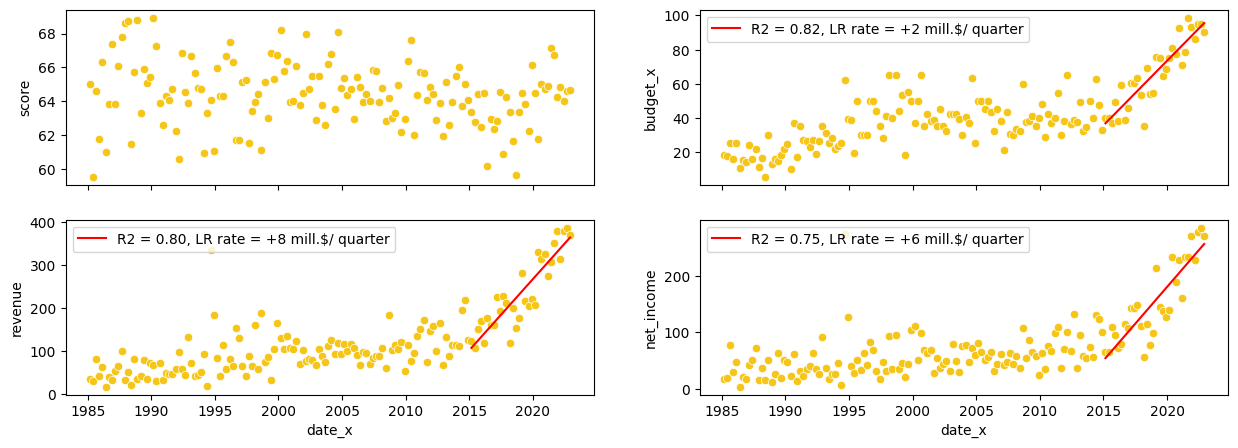

In [27]:
from sklearn.linear_model import LinearRegression

thres2015 = pd.Timestamp('2015-01-01')
df_quarterlypost2015 = df_quarterly[df_quarterly.index > thres2015]
x_fit = np.array(range(1, len(df_quarterlypost2015.index) + 1)).reshape(-1, 1)


fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
for i, col in enumerate(cols2plot):
    ax_ = ax[i // 2, i % 2]
    sns.scatterplot(data=df_quarterly[df_quarterly.index > thres1985], x=df_quarterly.index[df_quarterly.index > thres1985], y=col, color=imdbcolor, ax=ax_)
    if col != 'score':
        lr = LinearRegression().fit(x_fit, df_quarterlypost2015[col].values)
        col_pred = lr.predict(x_fit)
        r2 = lr.score(x_fit, df_quarterlypost2015[col].values)
        sns.lineplot(x=df_quarterlypost2015.index, y=col_pred, color='red', ax=ax_, label='R2 = %.2f, LR rate = +%.0f mill.$/ quarter' % (r2, lr.coef_[0]))

If we clip the data since 2015, we can see a clear and consistent positive trend in the ```budget_x```, ```revenue``` and ```net_income```, 2, 8 and 6 millions of dollars per quarter, respectively.

### Who are the actors with the most movies? And the best in terms of scoring in movies they participate in? <a class="anchor" id="actors-header"></a>

Text(0.5, 1.0, 'The 20 actors with the most films')

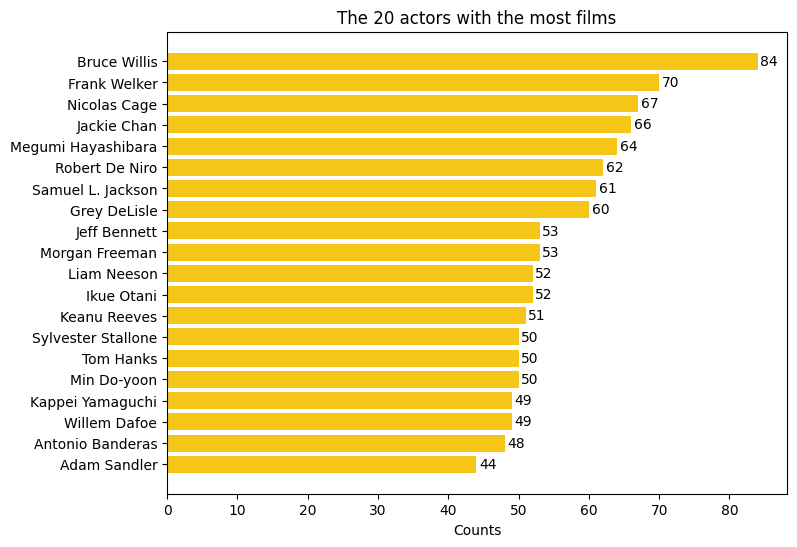

In [28]:
cast_unique = df['cast'].str.split(', ').explode('cast').value_counts().drop('')

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(cast_unique[:20].index[::-1], cast_unique[:20].values[::-1], color=imdbcolor)
ax.bar_label(bars, padding=2)
ax.set_xlabel('Counts')
ax.set_title('The 20 actors with the most films')

In [29]:
# Get the scores average of the actors that have at least 10 films in their filmography
df_topactors = cast_unique[cast_unique > 10].to_frame()
df_topactors['score'] = np.nan
for actor in df_topactors.index:
    mask_actor = [actor in film for film in df['cast'].str.split(', ')]
    df_topactors.loc[actor, 'score'] = df.loc[mask_actor, 'score'].replace(0, np.nan, inplace=False).agg({'score': 'mean'}).values

df_topactors.sort_values('score', ascending=False).head(20)

,count,score
cast,,
Megumi Ogata,13,78.076923
Inori Minase,11,77.636364
Maaya Uchida,11,77.272727
Yoshitsugu Matsuoka,13,77.076923
Mindy Cohn,20,75.850000
Miyu Irino,13,75.692308
Kotono Mitsuishi,17,75.647059
Yoshimasa Hosoya,11,75.545455
Ha Jung-woo,12,75.416667


With the above table we can see that the list of actors with the best ```scores``` in their movies are mainly Asian voice actors. Joe Pesci is the first Hollywood actor in this list, in the 12th position with an average of 75 of score.

In [30]:
# Let's find out which actress scores the highest (on average) in her films among a shortlist of the best actresses of all time.
best_actresses = ['Katharine Hepburn',
                  'Ingrid Bergman',
                  'Meryl Streep',
                  'Bette Davis',
                  'Olivia de Havilland',
                  'Vivien Leigh',
                  'Nicole Kidman',
                  'Michelle Yeoh',
                  'Jessica Chastain',
                  'Frances McDormand',
                  'Renée Zellweger',
                  'Julianne Moore',
                  'Jennifer Lawrence',
                  'Helen Mirren',
                  'Julia Roberts',
                  'Susan Sarandon',
                  'Jessica Lange',
                  'Emma Thompson',
                  'Kathy Bates',
                  'Elizabeth Taylor',
                  'Grace Kelly',
                  'Jodie Foster',
                  'Cate Blanchett',
                  'Kate Winslet',
                  'Natalie Portman',
                  'Judi Dench',
                  'Jamie Lee Curtis'
                  ]

df_topactors[df_topactors.index.isin(best_actresses)].sort_values('score', ascending=False)

,count,score
cast,,
Cate Blanchett,31,71.032258
Jodie Foster,14,70.000000
Meryl Streep,28,69.607143
Natalie Portman,19,69.105263
Kate Winslet,30,69.000000
Frances McDormand,19,68.947368
Jennifer Lawrence,16,68.533333
Jessica Chastain,22,68.409091
Emma Thompson,28,68.392857


So Cate Blanchett is the actress with better ```scores``` in her films, congratulations.